### Sample Model Pipeline

#### Complete-Case Analysis

In [9]:
CONTS = ['feature_5', 'feature_6', 'feature_7']
CATS = ['feature_0',
        'feature_1',
        'feature_2',
        'feature_3',
        'feature_4',
        'feature_10',
        'feature_11',
        'feature_12',
        'feature_8',
        'feature_9'
        ]

In [10]:
TARGET = 'target'

In [1]:
import pandas as pd

In [5]:
train = pd.read_csv("../data/splits/complete_df/train.csv")
test = pd.read_csv("../data/splits/complete_df/test.csv")

In [78]:
train[TARGET] = train[TARGET].astype('category').cat.codes
test[TARGET] = test[TARGET].astype('category').cat.codes

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [57]:
model = Pipeline([
        ('preprocessor', ColumnTransformer([
            ("enc", OneHotEncoder(drop='first'), CATS),
        ], remainder='passthrough')),
        ('clf', RandomForestClassifier()),
    ]) 

In [74]:
model.fit(train[CONTS + CATS], train[TARGET])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('enc',
                                                  OneHotEncoder(drop='first'),
                                                  ['feature_0', 'feature_1',
                                                   'feature_2', 'feature_3',
                                                   'feature_4', 'feature_10',
                                                   'feature_11', 'feature_12',
                                                   'feature_8',
                                                   'feature_9'])])),
                ('clf', RandomForestClassifier())])

In [87]:
from sklearn import metrics
preds = model.predict(test[CONTS + CATS])
preds_proba = model.predict_proba(test[CONTS + CATS])[:,1]
print(metrics.classification_report(test[TARGET], preds))
print("ROC-AUC: ", metrics.roc_auc_score(test[TARGET], preds_proba))

              precision    recall  f1-score   support

           0       0.79      0.47      0.59        32
           1       0.75      0.93      0.83        54

    accuracy                           0.76        86
   macro avg       0.77      0.70      0.71        86
weighted avg       0.76      0.76      0.74        86

ROC-AUC:  0.6892361111111112


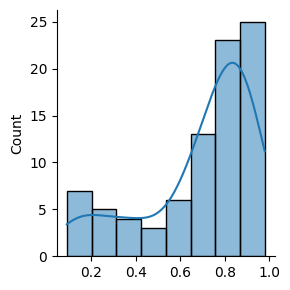

In [91]:
sns.displot(preds_proba, kde=True, height=3)